### Книжному интернет-магазину необходимо уметь предсказывать объём заказов, чтобы выделить необходимое количество сотрудников на сбор и упаковку и уменьшить задержки. Вам предстоит решить задачу предсказания товарооборота этого магазина.

In [309]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [311]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [312]:
df = pd.read_csv('data/tovar_moving.zip', parse_dates=['date'], index_col='date')
df.index.freq = 'D'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2009-12-25 to 2013-12-02
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qty     1439 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


* date — дата заказа;
* quantity (qty) — количество книг, заказанных в этот день.

In [313]:
df

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0
...,...
2013-11-28,320717.0
2013-11-29,444416.0
2013-11-30,323577.0


In [314]:
# Количество книг - целочисленный признак, преобразую
# df['qty'] = df['qty'].astype(int)

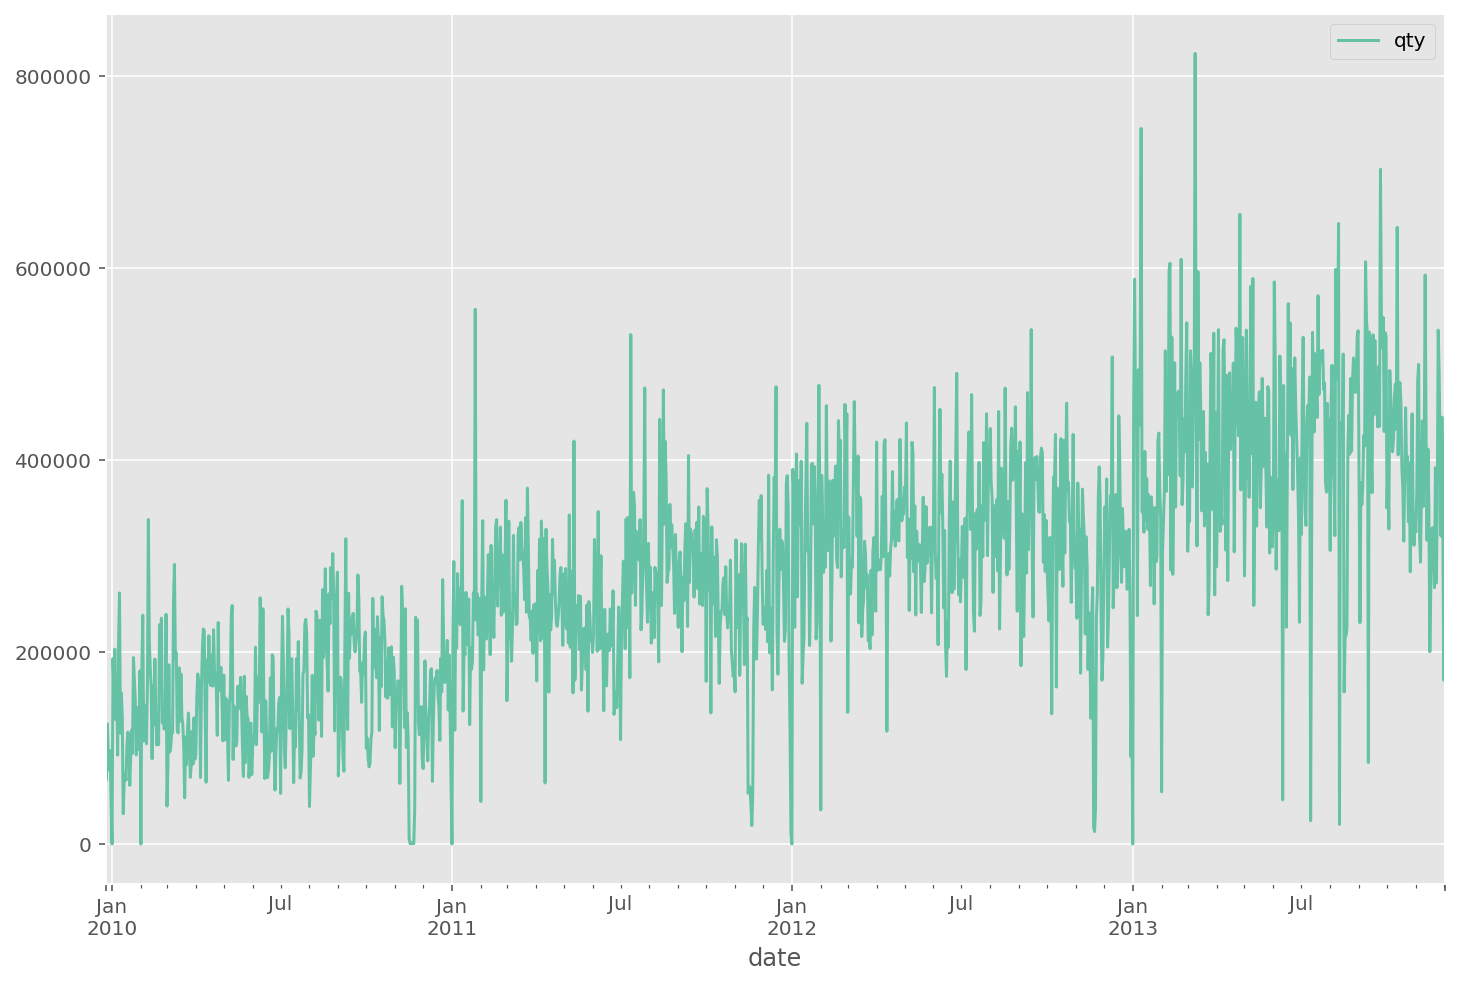

In [315]:
df.plot();

### Произвожу декомпозицию

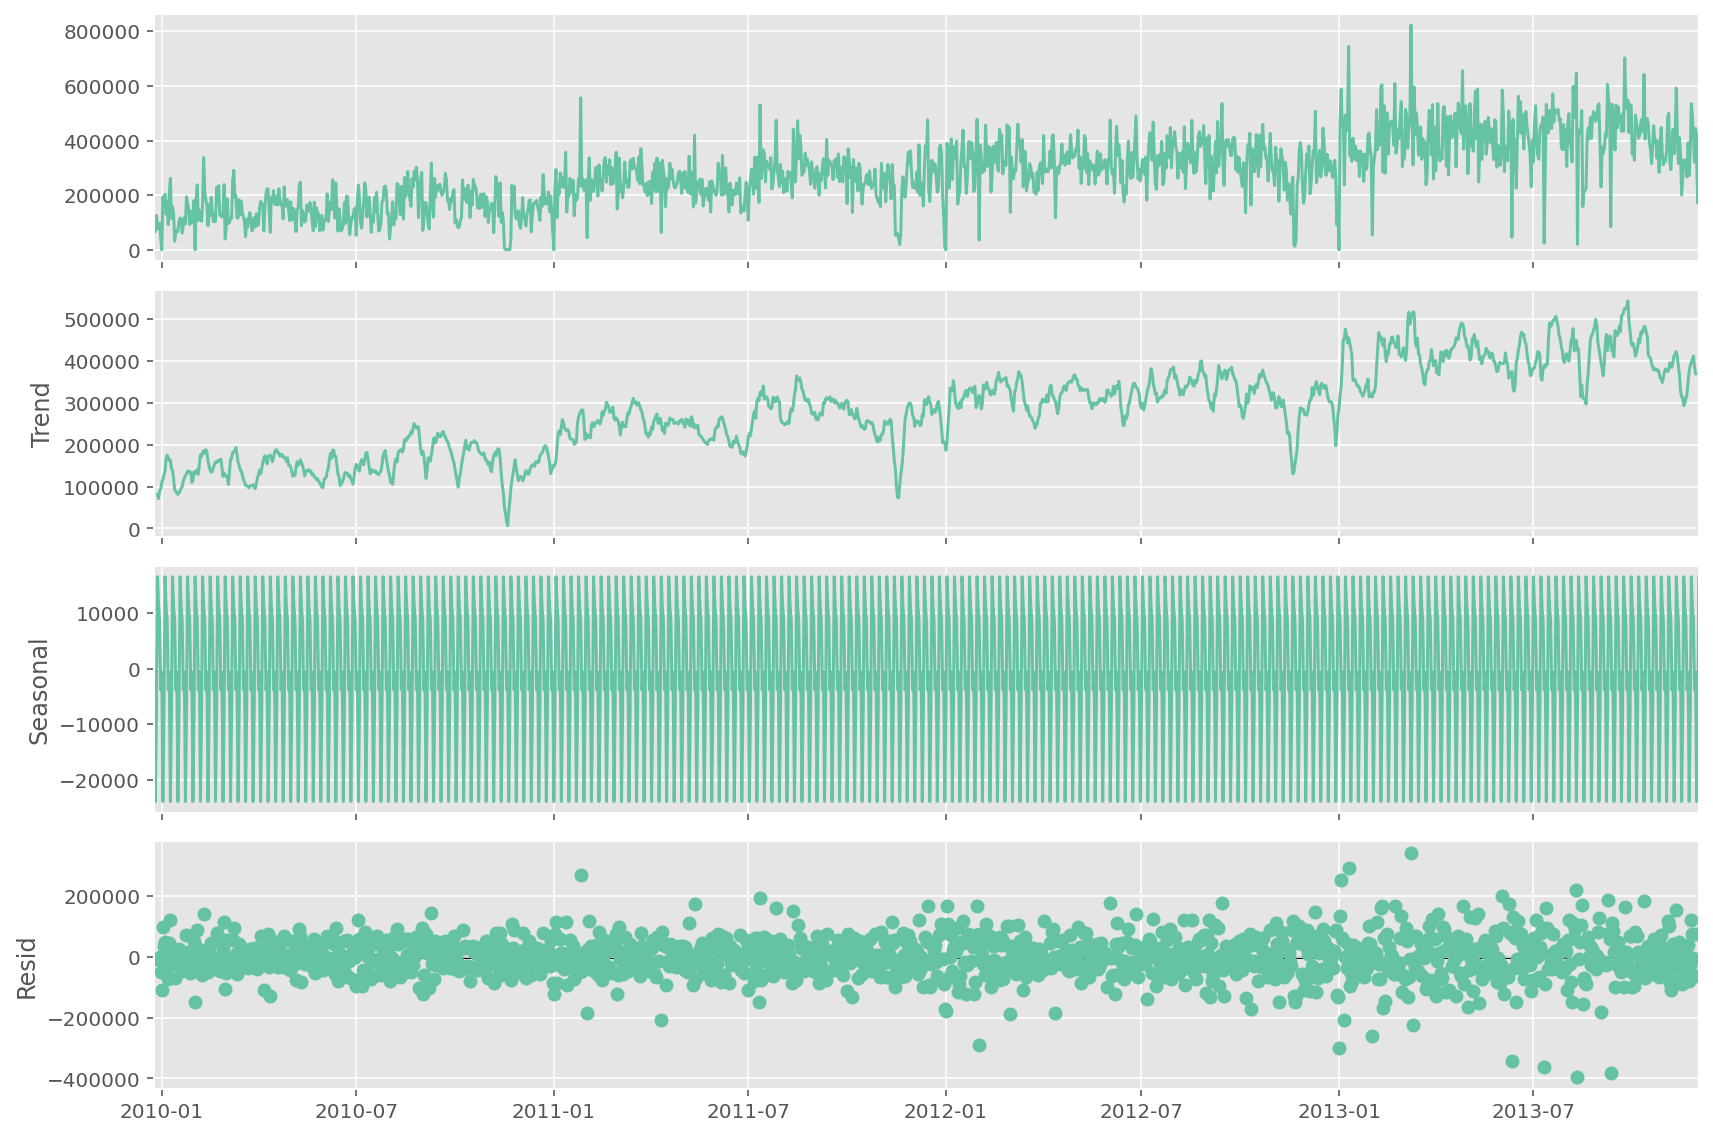

In [316]:
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show() # любуемся результатом

Видна сезонная составляющая и много шума. Тренд есть, но он достаточно неравномерный.

### Произвожу разделение выборок

In [317]:
predict_period = 1
train_df = df.iloc[:-predict_period]
test_df = df.iloc[-predict_period]
test_df

qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64

### Прогноз с помощью экспоненциального сглаживания

In [318]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)
exp_pred = model.forecast(1) # предсказание на 1 период
exp_pred

2013-12-02    225015.522647
Freq: D, dtype: float64

In [319]:
model_name = []
mape_value = []

In [320]:
model_name.append('SimpleExpSmoothing on base data')
mape_value.append(mean_absolute_percentage_error(test_df, exp_pred))

### Проверка временного ряда на стационарность

In [321]:
hd.adf(df)

Test-Statistic: -2.2379751493990585
P-Value: 0.192752395548408
Time series is non-stationary


Ряд нестационарен, необходимо дифференцирование

In [322]:
df_diff_1 = df.diff().dropna()
df_diff_1

,qty
date,
2009-12-26,-5728.0
2009-12-27,58613.0
2009-12-28,-33655.0
2009-12-29,-14549.0
2009-12-30,20294.0
...,...
2013-11-28,-95158.0
2013-11-29,123699.0
2013-11-30,-120839.0


In [323]:
hd.adf(df_diff_1)

Test-Statistic: -13.821839865226677
P-Value: 7.878856681049184e-26
Time series is stationary!


Произвожу разделение для стационарного ряда

In [324]:
predict_period = 1
train_df_diff_1 = df_diff_1.iloc[:-predict_period]
test_df_diff_1 = df_diff_1.iloc[-predict_period]

### Прогноз с помощью экспоненциального сглаживания для стационарного временного ряда

In [325]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df_diff_1)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)
exp_pred = model.forecast(1)
exp_pred

2013-12-02   -126817.886177
Freq: D, dtype: float64

In [326]:
last_value = train_df.iloc[-1, 0]
exp_pred[0] + last_value

43847.11382336421

In [327]:
last_value = train_df.iloc[-1]
ar_pred_original_scale = exp_pred[0] + last_value
ar_pred_original_scale

qty    43847.113823
Name: 2013-12-01 00:00:00, dtype: float64

In [328]:
model_name.append('SimpleExpSmoothing on diff data')
mape_value.append(mean_absolute_percentage_error(df.iloc[-1], ar_pred_original_scale))

In [329]:
mape_value

[0.46911018943878297, 0.8965494216688038]

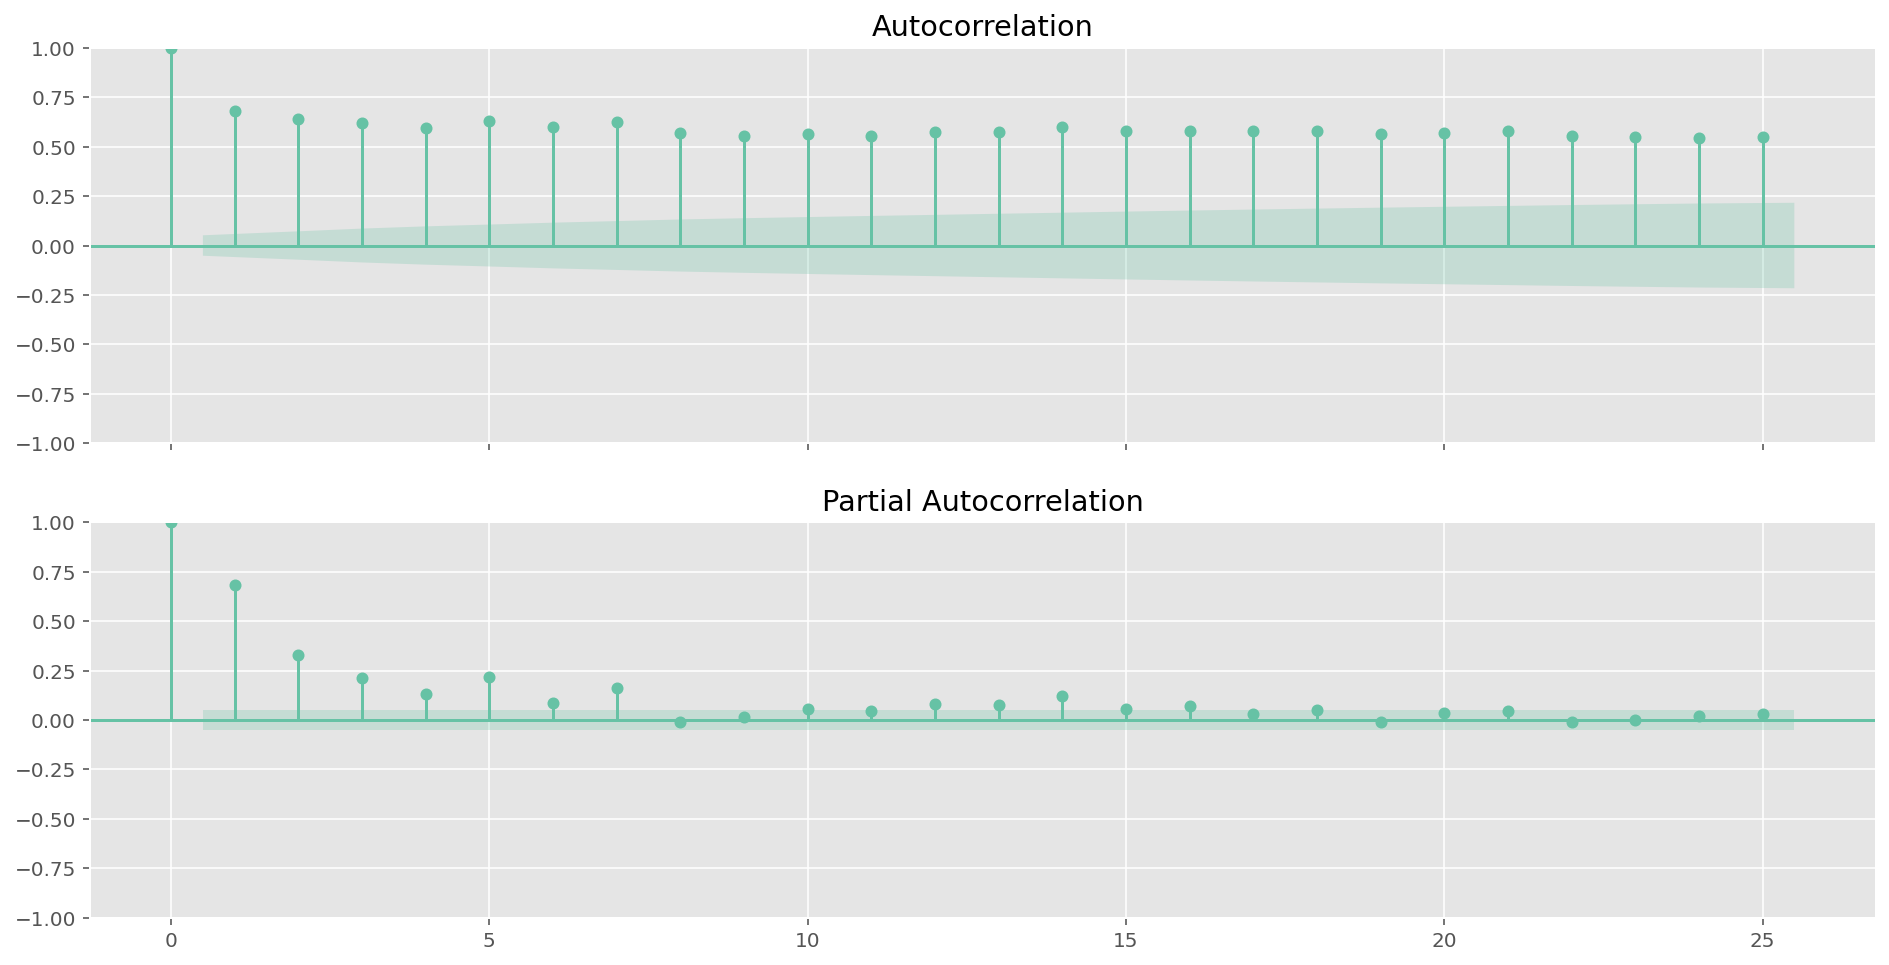

In [330]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=lags, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_df, lags=lags, ax=ax[1])
plt.show()

по pacf видим что последним лагом, отличным от нуля является 6 лаг

In [331]:
from statsmodels.tsa.ar_model import AutoReg

p = 6
ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Wed, 26 Jul 2023   AIC                          36458.111
Time:                        15:51:25   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

2013-12-02    318174.284553
Freq: D, dtype: float64

In [332]:
model_name.append('AutoReg on base data')
mape_value.append(mean_absolute_percentage_error(test_df, ar_pred))

In [333]:
p = 6
ar_model = AutoReg(train_df_diff_1, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df_diff_1), end=(len(train_df_diff_1)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1437
Model:                     AutoReg(6)   Log Likelihood              -18197.626
Method:               Conditional MLE   S.D. of innovations          80642.497
Date:                Wed, 26 Jul 2023   AIC                          36411.251
Time:                        15:51:25   BIC                          36453.380
Sample:                    01-01-2010   HQIC                         36426.983
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        625.7761   2132.009      0.294      0.769   -3552.885    4804.437
qty.L1        -0.6928      0.026    -26.583      0.000      -0.744      -0.642
qty.L2        -0.5560      0.031    -17.749      0.0

2013-12-02    183773.199142
Freq: D, dtype: float64

In [334]:
last_value = train_df.iloc[-1]
ar_pred_original_scale = ar_pred[0] + last_value
ar_pred_original_scale

qty    354438.199142
Name: 2013-12-01 00:00:00, dtype: float64

In [335]:
model_name.append('AutoReg on diff data')
mape_value.append(mean_absolute_percentage_error(df.iloc[-1], ar_pred_original_scale))

In [338]:
(pd.DataFrame({'MAPE %': mape_value}, index=model_name) * 100).round(2)

,MAPE %
SimpleExpSmoothing on base data,46.91
SimpleExpSmoothing on diff data,89.65
AutoReg on base data,24.93
AutoReg on diff data,16.38
